In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

## Implementation of a Generative Adversarial Network (Goodfellow et al.)

- A GAN learns a sampler that generates data points that have the same distribution as the data distribution.
- It consists of a generator network $G$ and a discriminator network $D$

<img src="figures/gan.png" style="width: 400px;"/>

- $G$ is trained to generate fake samples
- $D$ should learn to distinguish fake and real samples
- Boths networks are updated in turns

To train a GAN the following optimization problem is solved

$$ min_G \; max_D \; \mathbb{E}_{X \sim p_{data}} log(D(X)) + \mathbb{E}_{Z \sim p_{latent}} log(1-D(G(Z)))$$

Paper: https://arxiv.org/abs/1406.2661

## 1. Learning to Smaple from a Two-dimensional Distribution

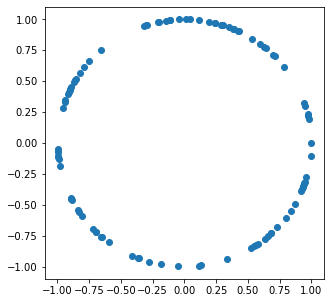

In [2]:
def get_training_data(batch_size=32):
    r = 2*np.pi*torch.rand((batch_size, 1))
    x = torch.sin(r)
    y = torch.cos(r)
    return torch.hstack([x, y])

train_data = get_training_data(100)
plt.figure(figsize=(5,5))
plt.scatter(train_data[:,0], train_data[:,1])

In [3]:
class Generator2d(nn.Module):
    def __init__(self):
        super(Generator2d, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),
            nn.Linear(20, 2))

    def forward(self, z):
        return self.layers(z)

In [4]:
class Discriminator2d(nn.Module):
    def __init__(self):
        super(Discriminator2d, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),
            nn.Linear(20, 1),
            nn.Sigmoid())

    def forward(self, z):
        return self.layers(z)

In [5]:
G = Generator2d()
D = Discriminator2d()

In [6]:
lr = 0.0001
batch_size = 150
opt_G = torch.optim.Adam(G.parameters(), lr=lr)
opt_D = torch.optim.Adam(D.parameters(), lr=lr)

epoch: 5000 loss: 1.393


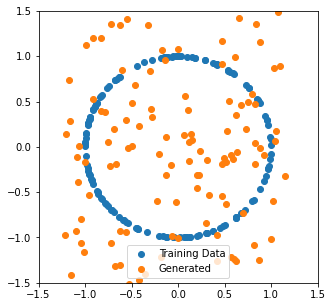

epoch: 10000 loss: 1.385


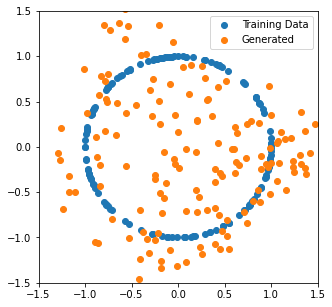

epoch: 15000 loss: 1.385


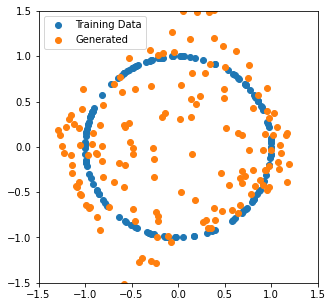

epoch: 20000 loss: 1.386


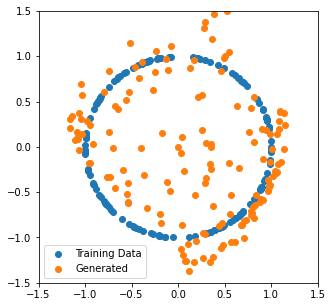

epoch: 25000 loss: 1.386


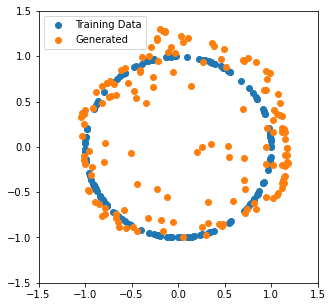

epoch: 30000 loss: 1.385


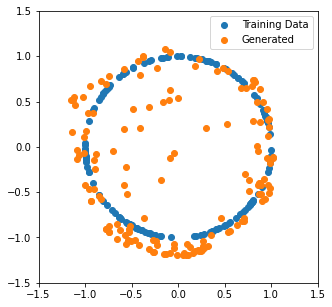

epoch: 35000 loss: 1.386


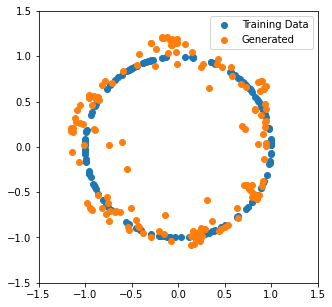

epoch: 40000 loss: 1.385


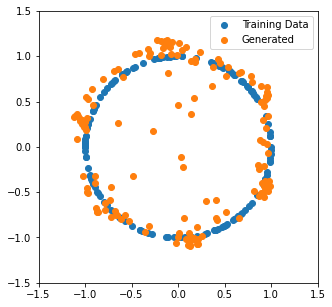

epoch: 45000 loss: 1.386


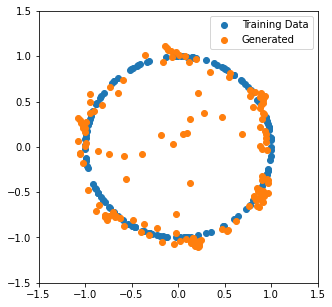

epoch: 50000 loss: 1.386


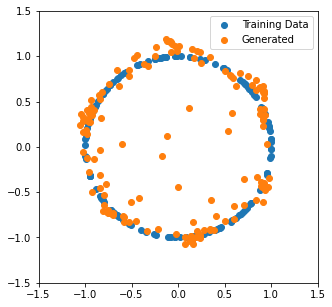

epoch: 55000 loss: 1.386


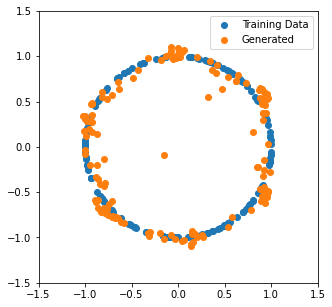

epoch: 60000 loss: 1.386


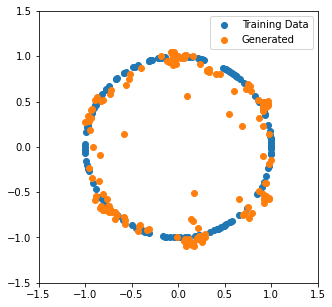

epoch: 65000 loss: 1.386


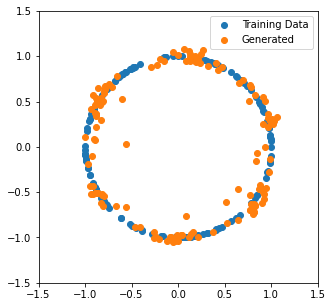

epoch: 70000 loss: 1.386


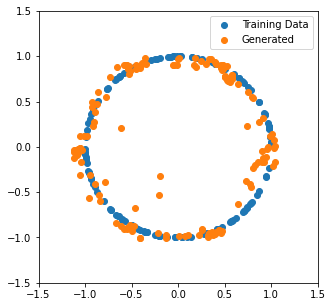

epoch: 75000 loss: 1.386


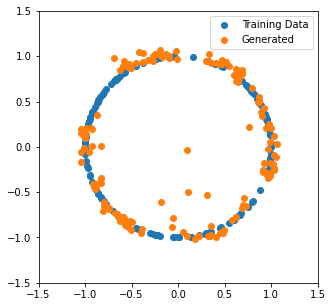

epoch: 80000 loss: 1.387


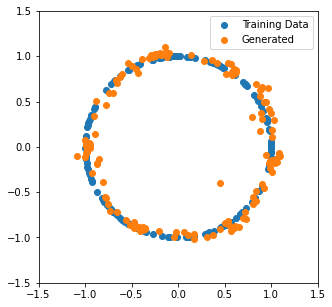

epoch: 85000 loss: 1.386


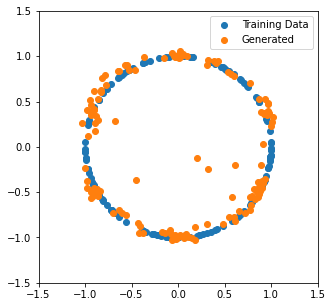

epoch: 90000 loss: 1.386


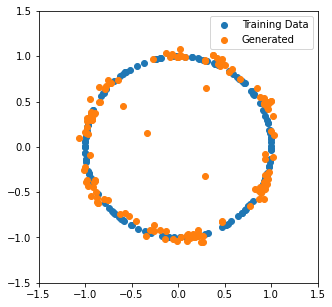

epoch: 95000 loss: 1.387


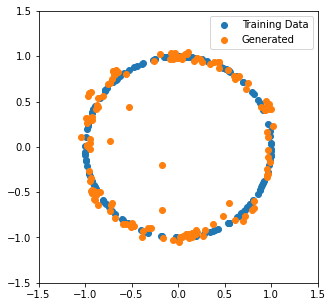

epoch: 100000 loss: 1.385


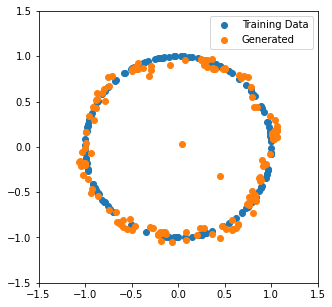

In [7]:
epochs = 100000
history = []

for i in range(epochs):
    z = torch.randn(batch_size, 2)
    x = get_training_data(batch_size)
    # Train step D
    opt_D.zero_grad()
        
    loss_D = -torch.log(D(x)).mean()-torch.log(1-D(G(z))).mean()
    history.append(float(loss_D))
    loss_D.backward()
    opt_D.step()
        
    # Train step G
    opt_G.zero_grad()
    loss_G = -torch.log(D(G(z))).mean() # minor modification of the loss
    loss_G.backward()
    opt_G.step()
        
    if (i+1)%5000==0:
        print("epoch: {:2} loss: {:3.4}".format(i+1, history[-1]))
        z = torch.randn(batch_size,2)
        samples = G(z).detach().numpy()
        plt.figure(figsize=(5,5))
        plt.scatter(x[:,0], x[:,1], label='Training Data')
        plt.scatter(samples[:,0], samples[:,1], label='Generated')
        plt.xlim((-1.5,1.5))
        plt.ylim((-1.5,1.5))
        plt.legend()
        plt.show()

## 2. Learning to Generate New MNIST Digits

In [8]:
batch_size = 32
tr = transforms.Compose([transforms.ToTensor()])

training_set = torchvision.datasets.MNIST(root='./data', train=True,
                                          download=True, transform=tr)
training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size,
                                              shuffle=True, num_workers=1)

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(50, 256),
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.Tanh(),
            nn.Linear(256, 28*28),
            nn.Sigmoid())

    def forward(self, z):
        z = self.layers(z)
        z = z.view(-1,1,28,28)
        return z

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.Tanh(),
            nn.Linear(256, 1),
            nn.Sigmoid())

    def forward(self, x):
        x = x.view(-1,28*28)
        x = self.layers(x)
        return x

In [11]:
G = Generator()
D = Discriminator()

In [12]:
lr = 0.001
opt_G = torch.optim.RMSprop(G.parameters(), lr=lr)
opt_D = torch.optim.RMSprop(D.parameters(), lr=lr)

In [13]:
from util import plot_grid

epoch:  1 batch:  500 loss: 1.081


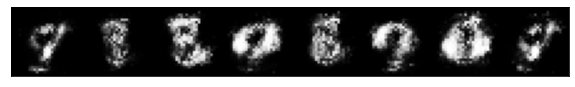

epoch:  1 batch: 1000 loss: 0.7553


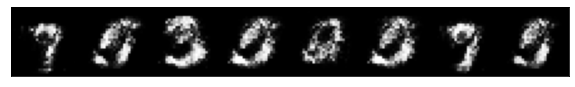

epoch:  1 batch: 1500 loss: 0.7678


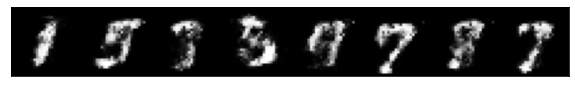

epoch:  2 batch:  500 loss: 0.5781


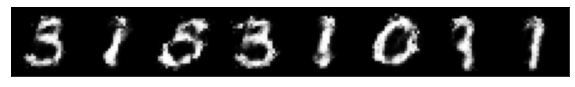

epoch:  2 batch: 1000 loss: 0.6458


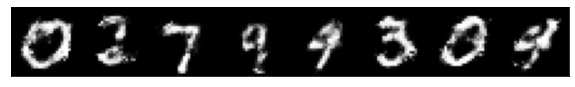

epoch:  2 batch: 1500 loss: 1.335


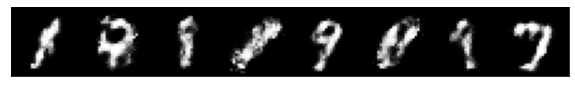

epoch:  3 batch:  500 loss: 0.8754


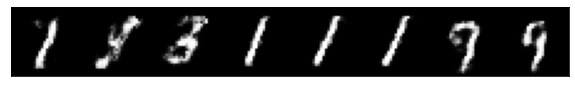

epoch:  3 batch: 1000 loss: 0.7508


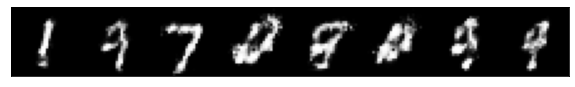

epoch:  3 batch: 1500 loss: 0.4264


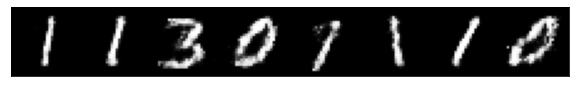

In [14]:
epochs = 3
history = []

for i in range(epochs):
    for j, (x, _) in enumerate(training_loader):
        z = torch.randn(batch_size,1,50)
    
        # Train step D
        opt_D.zero_grad()
        
        loss_D = -torch.log(D(x)).mean()-torch.log(1-D(G(z))).mean()
        history.append(float(loss_D))
        loss_D.backward()
        opt_D.step()
        
        # Train step G
        opt_G.zero_grad()
        loss_G = -torch.log(D(G(z))).mean() # minor modification of the loss
        loss_G.backward()
        opt_G.step()
        
        if (j+1)%500==0:
            print("epoch: {:2} batch: {:4} loss: {:3.4}".format(i+1, j+1, history[-1]))
            z = torch.randn(8,1,50)
            plot_grid(G(z).detach().numpy(), grid_size=(8,1))

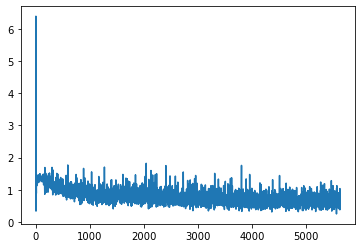

In [15]:
plt.plot(history);

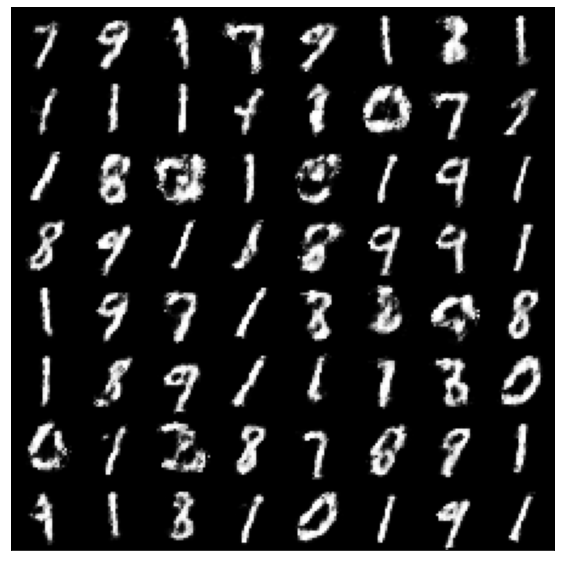

In [16]:
z = torch.randn(64,1,50)
img = G(z).detach().numpy()
plot_grid(img)

In [17]:
# Save model to disk

# torch.save(G.state_dict(), "gan_G")
# torch.save(D.state_dict(), "gan_D")

In [18]:
# Load model
# G = Generator()
# G.load_state_dict(torch.load("gan_G"))
# D = Discriminator()
# D.load_state_dict(torch.load("gan_D"))